In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sharansmenon/animals141

 94% 57.0M/60.5M [00:00<00:00, 86.3MB/s]
100% 60.5M/60.5M [00:00<00:00, 68.6MB/s]


In [ ]:
!unzip animals141.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/dataset/ceratitis-capitata/ceratitis-capitata_92_1364760f.jpg  
  inflating: dataset/dataset/ceratitis-capitata/ceratitis-capitata_93_df914c32.jpg  
  inflating: dataset/dataset/ceratitis-capitata/ceratitis-capitata_94_fd5647fe.jpg  
  inflating: dataset/dataset/ceratitis-capitata/ceratitis-capitata_96_b1b70c45.jpg  
  inflating: dataset/dataset/ceratitis-capitata/ceratitis-capitata_97_b7c264e5.jpg  
  inflating: dataset/dataset/ceratotherium-simum/ceratotherium-simum_18_4fcf8ad3.jpg  
  inflating: dataset/dataset/ceratotherium-simum/ceratotherium-simum_18_7565c9eb.jpg  
  inflating: dataset/dataset/ceratotherium-simum/ceratotherium-simum_19_8b607f2d.jpg  
  inflating: dataset/dataset/ceratotherium-simum/ceratotherium-simum_19_ced6ec21.jpg  
  inflating: dataset/dataset/ceratotherium-simum/ceratotherium-simum_27_44d0cb97.jpg  
  inflating: dataset/dataset/ceratotherium-simum/ceratotherium-simum_40_a33981f4.jpg  
  

In [ ]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [ ]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


In [ ]:
class ImageClassificationModel(nn.Module):
    def __init__(self, num_classes=3):
        super(ImageClassificationModel, self).__init__()
        self.model = models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [ ]:
with open('translation.json', 'r') as json_file:
    translations = json.load(json_file)

In [ ]:
data_dir = './dataset/dataset'
num_classes = len(translations)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
dataset = ImageFolder(data_dir, transform=transform)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
val_size = int(0.15 * len(dataset))
test_size = int(0.15 * len(dataset))
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
num_epochs = 10
batch_size = 32
lr=0.001

In [ ]:
training_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
model = to_device(ImageClassificationModel(num_classes), device)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 295MB/s]


In [ ]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_samples = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc = 100.0 * train_correct / total_samples

    return train_loss, train_acc

In [ ]:
def evaluate(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    val_loss /= len(dataloader)
    val_acc = 100.0 * val_correct / total_samples

    return val_loss, val_acc

In [ ]:
def fit(model, train_dataloader, val_dataloader, optimizer, criterion, num_epochs):
    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, train_dataloader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_dataloader, criterion)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

In [ ]:
fit(model, training_dl, val_dl, optimizer, criterion, num_epochs)

Epoch [1/10], Train Loss: 4.2727, Train Acc: 24.85%, Val Loss: 2.9935, Val Acc: 50.43%
Epoch [2/10], Train Loss: 2.4099, Train Acc: 62.60%, Val Loss: 1.6436, Val Acc: 71.91%
Epoch [3/10], Train Loss: 1.4201, Train Acc: 79.98%, Val Loss: 1.0561, Val Acc: 81.28%
Epoch [4/10], Train Loss: 0.9090, Train Acc: 88.77%, Val Loss: 0.7782, Val Acc: 86.70%
Epoch [5/10], Train Loss: 0.6133, Train Acc: 93.55%, Val Loss: 0.6084, Val Acc: 88.40%
Epoch [6/10], Train Loss: 0.4384, Train Acc: 95.92%, Val Loss: 0.5189, Val Acc: 90.00%
Epoch [7/10], Train Loss: 0.3187, Train Acc: 97.70%, Val Loss: 0.4751, Val Acc: 90.96%
Epoch [8/10], Train Loss: 0.2333, Train Acc: 98.50%, Val Loss: 0.4311, Val Acc: 91.38%
Epoch [9/10], Train Loss: 0.1833, Train Acc: 99.32%, Val Loss: 0.4108, Val Acc: 90.85%
Epoch [10/10], Train Loss: 0.1407, Train Acc: 99.45%, Val Loss: 0.3943, Val Acc: 91.81%


In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img. unsqueeze(0), device)
     # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _,preds = torch.max(yb, dim=1)
    # Retrieve the class label
    return translations[dataset.classes [preds[0].item()]]

In [ ]:
correct=0
for i in range(len(test_ds)):
  img,label=test_ds[i];
  if(predict_image(img,model)==translations[dataset.classes[label]]):
    correct+=1
print(correct/len(test_ds)*100)

91.80851063829788


Label : Dead Man's Fingers ,Predicted : Dead Man's Fingers


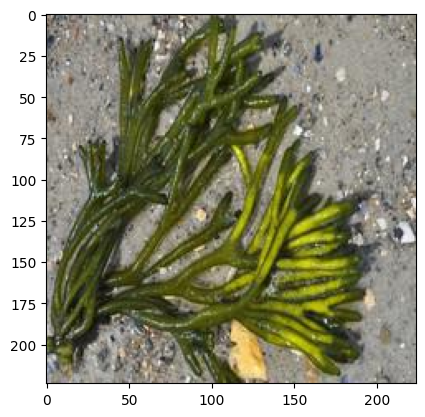

In [ ]:
import matplotlib.pyplot as plt

img , label = test_ds[1]
plt.imshow(img.permute(1,2,0))
print('Label :', translations[dataset.classes[label]], ',Predicted :', predict_image(img,model))